# Heart Failure Research (Work in Progress)

Congestive heart Failure (CHF) is a common condition causing morbidity and mortality, especially in the older population. According to the Center of Disease Control and Prevention, in the USA, heart failure was a contributing cause of 1 in 8 deaths in 2017 and created a cost of approximately 30.7 billion dollars.

It is of great interest to further study CHF to alleviate the societal and economical burden, which this disease is causing. 

I this notebook I explore and clean the data of dutch unstructured electronic health records (EHR). Afterwards, I implement the LSTM architecture to build a classifier which can predict the outcome of a patient only based on the clinical text. Several baseline models are used to compare the performance of the LSTM. Also, an attention based model is implemented.

__Due to GDPR I cannot use the full data in this public notebook and therefore, the results of the models seen here are not representative for the study.__

__Also I needed to clear all output of text cells so no sensitive information about patients is being made public.__

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string

import nltk
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud
from tqdm import tqdm
import matplotlib.style as style
style.use('fivethirtyeight')
from sklearn.metrics import plot_roc_curve
from numpy import interp
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


In [ ]:
os.chdir("/home/leon/Documents/HF_Research")

In [ ]:
df5 = pd.read_csv('subset_documents.cvs', sep = '\t')

In [6]:
#df5.head(10)

In [7]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646 entries, 0 to 645
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Unnamed: 0            646 non-null    int64 
 1   Patnr                 646 non-null    int64 
 2   Geslacht              646 non-null    int64 
 3   Geboortejaar          646 non-null    int64 
 4   Datum van overlijden  292 non-null    object
 5   Tekst_x               47 non-null     object
 6   Tekst_y               184 non-null    object
 7   Tekst_x.1             586 non-null    object
 8   Tekst_y.1             602 non-null    object
 9   Document              646 non-null    int64 
 10  Arts                  644 non-null    object
 11  clean_text            586 non-null    object
dtypes: int64(5), object(7)
memory usage: 60.7+ KB


In [8]:
df5.isna().sum()/len(df5)*100

Unnamed: 0               0.000000
Patnr                    0.000000
Geslacht                 0.000000
Geboortejaar             0.000000
Datum van overlijden    54.798762
Tekst_x                 92.724458
Tekst_y                 71.517028
Tekst_x.1                9.287926
Tekst_y.1                6.811146
Document                 0.000000
Arts                     0.309598
clean_text               9.287926
dtype: float64

# Cleaning

In [9]:
def remove_line_breaks(text):
    text = text.replace('\r', ' ').replace('\n', ' ')
    return text

#remove punctuation
def remove_punctuation(text):
    re_replacements = re.compile("__[A-Z]+__")  # such as __NAME__, __LINK__
    re_punctuation = re.compile("[%s]" % re.escape(string.punctuation))
    '''Escape all the characters in pattern except ASCII letters and numbers: word_tokenize('ebrahim^hazrati')'''
    tokens = word_tokenize(text)
    tokens_zero_punctuation = []
    for token in tokens:
        if not re_replacements.match(token):
            token = re_punctuation.sub(" ", token)
        tokens_zero_punctuation.append(token)
    return ' '.join(tokens_zero_punctuation)

def remove_special_characters(text):
    text = re.sub('[^a-zA-z0-9\s]', '', text)
    return text

def lowercase(text):
    text_low = [token.lower() for token in word_tokenize(text)]
    return ' '.join(text_low)

def remove_stopwords(text):
    stop = set(stopwords.words('dutch'))
    word_tokens = nltk.word_tokenize(text)
    text = " ".join([word for word in word_tokens if word not in stop])
    return text

#remove punctuation
def remove_punctuation(text):
    re_replacements = re.compile("__[A-Z]+__")  # such as __NAME__, __LINK__
    re_punctuation = re.compile("[%s]" % re.escape(string.punctuation))
    '''Escape all the characters in pattern except ASCII letters and numbers: word_tokenize('ebrahim^hazrati')'''
    tokens = word_tokenize(text)
    tokens_zero_punctuation = []
    for token in tokens:
        if not re_replacements.match(token):
            token = re_punctuation.sub(" ", token)
        tokens_zero_punctuation.append(token)
    return ' '.join(tokens_zero_punctuation)

#remobe one character words
def remove_one_character_words(text):
    '''Remove words from dataset that contain only 1 character'''
    text_high_use = [token for token in word_tokenize(text) if len(token)>1]      
    return ' '.join(text_high_use)   

##remove specific word list
def remove_special_words(text):
    '''Remove the User predefine useless words from the text. The list should be in the lowercase.'''
    special_words_list=['af', 'iv', 'ivm', 'mg', 'dd', 'vrijdag','afspraak','over','met', 'van', 'patient', 'dr', 'geyik','heyman','bekker','dries','om', 'sel', 'stipdonk', 'eurling', 'knackstedt'
                        'lencer','volder','schalla']# list : words
    querywords=text.split()
    textwords = [word for word in querywords if word.lower() not in special_words_list]
    text=' '.join(textwords)
    return text
    
#%%
# Stemming with 'Snowball Dutch stemmer" package
def stem(text):
    stemmer = nltk.stem.snowball.SnowballStemmer('dutch')
    text_stemmed = [stemmer.stem(token) for token in word_tokenize(text)]        
    return ' '.join(text_stemmed)

def lemma(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    word_tokens = nltk.word_tokenize(text)
    text_lemma = " ".join([wordnet_lemmatizer.lemmatize(word) for word in word_tokens])       
    return ' '.join(text_lemma)


#break sentences to individual word list
def sentence_word(text):
    word_tokens = nltk.word_tokenize(text)
    return word_tokens
#break paragraphs to sentence token 
def paragraph_sentence(text):
    sent_token = nltk.sent_tokenize(text)
    return sent_token    


def tokenize(text):
    """Return a list of words in a text."""
    return re.findall(r'\w+', text)

def remove_numbers(text):
    no_nums = re.sub(r'\d+', '', text)
    return ''.join(no_nums)



def normalization_pitchdecks(text):
    _steps = [
    remove_line_breaks,
    remove_one_character_words,
    remove_special_characters,
    lowercase,
    remove_punctuation,
    remove_stopwords,
    remove_special_words,
    stem,
    remove_numbers
]
    for step in _steps:
        text=step(text)
    return text   
#%%

## Create label column

Datum van overlijden = Date on which the patient passed

In [10]:
df5['dead'] = np.where(df5['Datum van overlijden'].isna() == True , 0, 1)
df5['dead'] = pd.Categorical(df5['dead'])

In [11]:
# check for class balance

df5['dead'].value_counts()/len(df5)*100

0    54.798762
1    45.201238
Name: dead, dtype: float64

## Clean text and store in seperate columns in df5

In [12]:
 df5 = df5.replace(np.nan, '', regex=True)   # change NaN to empty string

In [13]:
Tekst_x = []
Tekst_x_1 = []
Tekst_y = []
Tekst_y_1 = []


for i in tqdm(df5['Tekst_x']):
    Tekst_x.append(normalization_pitchdecks(i)) 
    
for i in tqdm(df5['Tekst_x.1']):
    Tekst_x_1.append(normalization_pitchdecks(i))
    
for i in tqdm(df5['Tekst_y']):
    Tekst_y.append(normalization_pitchdecks(i))
    
for i in tqdm(df5['Tekst_y.1']):
    Tekst_y_1.append(normalization_pitchdecks(i))

100%|██████████| 646/646 [00:00<00:00, 823.43it/s]


In [14]:
df5['x_clean'] = pd.Series(Tekst_x)
df5['y_clean'] = pd.Series(Tekst_y)
df5['x_1_clean'] = pd.Series(Tekst_x_1)
df5['y_1_clean'] = pd.Series(Tekst_y_1)

In [17]:
#df5.head(10)

# Wordcloud

In [ ]:
doc_list = df5['x_1_clean'].dropna().tolist()
doc_list[:5]

(-0.5, 1599.5, 799.5, -0.5)

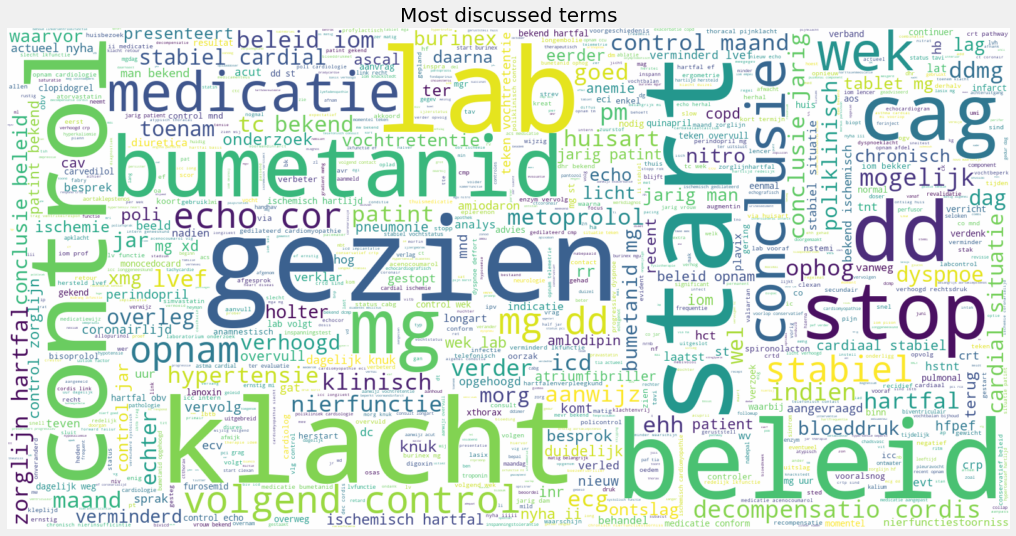

In [19]:
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="white", max_words=1000, max_font_size= 200,  width=1600, height=800)
wc.generate(" ".join(doc_list))
plt.title("Most discussed terms", fontsize=20)
plt.imshow(wc.recolor( colormap= 'viridis' , random_state=17), alpha=0.98, interpolation="bilinear", )
plt.axis('off')

In [20]:
ls= []

for i in doc_list:
    ls.append(str(i).split())

In [21]:
fdist = FreqDist()

for sentence in ls:
    for token in sentence:
        fdist[token] +=1

In [22]:
top_title = fdist.most_common(20)

In [23]:
ls = []
for i in top_title:
    ls.append({'Word': i[0], 'Num': i[1]})

df = pd.DataFrame(ls)

In [24]:
co = sns.cubehelix_palette(n_colors=20,
                           start=0,
                           rot=0.4,
                           gamma=1.0,
                           hue=0.8,
                           light=0.85,
                           dark=0.15,
                           reverse=True,
                           as_cmap=False)

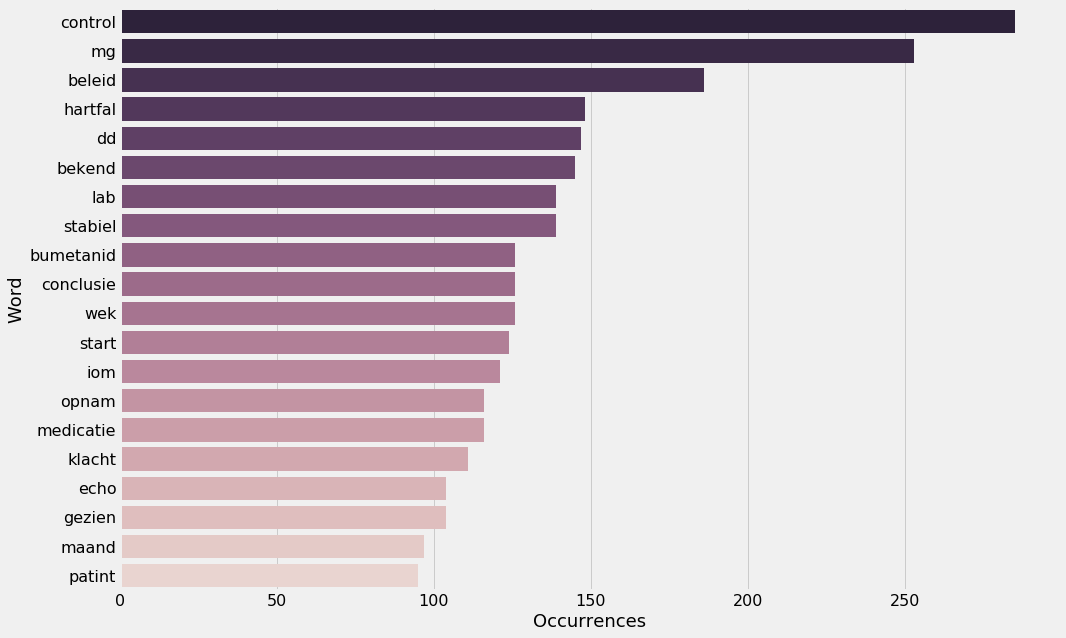

In [25]:
plt.figure(figsize=(15,10))

sns.barplot(data = df, y = 'Word', x = 'Num', palette=co)
plt.xlabel('Occurrences', fontsize=18)
plt.ylabel('Word', fontsize=18)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)

# I create a column which contains the text of all columns for each row and insert the wordcloud and word frequency of this column below

In [ ]:
df5["full"] = df5["x_clean"] +" "+ df5["x_1_clean"] +" "+ df5['y_1_clean'] +" "+ df5['y_clean']
df5['full'].iloc[0]

In [ ]:
df5['Patnr'].nunique()  # 131 unqiue patients

### Group by 'Patientnr' and 'label', and join together the different text fields for every patient

In [18]:
combined = df5.groupby(['Patnr', 'dead'])['full'].apply(lambda x: ' '.join(x.astype(str))).reset_index()

In [21]:
len(combined)

131

# Keras

In [22]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.layers import LSTM, Bidirectional
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.layers import Layer

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics



Using TensorFlow backend.


## Prepare input for LSTM

In [23]:
docs = combined['full'].tolist()

labels = combined['dead'].values

In [ ]:
docs[1]

In [25]:
print(len(docs)) #check if length is the same
print('\n')
print(len(labels))

131


131


In [26]:
df5['dead'].value_counts()

0    354
1    292
Name: dead, dtype: int64

In [27]:
# check number of unique words to estimate a reasonable vocab size

one_str = ''.join(docs)
unique_words = Counter(one_str.split())
len(unique_words) 

4056

In [28]:
vocab_size = 4056  
encoded_docs = [one_hot(d, vocab_size) for d in docs]
print(encoded_docs[:2])

[[19613, 22241, 7773, 32169, 4064, 35520, 17196, 39246, 32724, 7773, 32764, 40957, 14088, 33015, 32513, 21979, 25848, 14088, 116, 788, 2939, 37927, 8415, 18319, 30602, 5832, 19404, 7946, 1957, 21005, 3381, 32513, 37535, 6563, 40773, 42161, 19256, 26989, 41827, 17372, 467, 41876, 10227, 34301, 26989, 19404, 24522, 35738, 38286, 21979, 20748, 30588, 32560, 36405, 33009, 13085, 42318, 2679, 45462, 3221, 9170, 37648, 31623, 19160, 31623, 37539, 17160, 16126, 5165], [19613, 44626, 7773, 33851, 28424, 18132, 45448, 15001, 6928, 41014, 31016, 10787, 20128, 29178, 38795, 17067, 2155, 22407, 33405, 558, 27784, 25040, 9855, 33501, 194, 3149, 25201, 37820, 7613, 11995, 42173, 2939, 45320, 31016, 11995, 29137, 10787, 20128, 5439, 35400, 9528, 39730, 7524, 27915, 2939, 7524, 29137, 27784, 25040, 9855, 1700, 20404, 44718, 6975, 33968, 28241, 34747, 16244, 43131, 28241, 14284, 26989, 22407, 33405, 7773, 26556, 12776, 32304, 34442, 37180, 15993, 15876, 9401, 32515, 8687, 17067, 44151, 35255, 40146, 35

In [29]:
x = []

for i in encoded_docs:
    x.append(len(i))
    
print("In my sample the largest document has", max(x), "words.")

In my sample the largest document has 1331 words.


In [30]:
len(x)

131

In [31]:
# now every document will be represented by a vector of the same length: 1331 values 

max_length = 1331
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)

[[19613 22241  7773 ...     0     0     0]
 [19613 44626  7773 ...     0     0     0]
 [42991   116 35873 ...     0     0     0]
 ...
 [19613 42625 25078 ...     0     0     0]
 [42991 30339 20884 ...     0     0     0]
 [10138 35680 12603 ...     0     0     0]]


In [32]:
X = padded_docs
y = labels

df5.dtypes

Unnamed: 0                 int64
Patnr                      int64
Geslacht                   int64
Geboortejaar               int64
Datum van overlijden      object
Tekst_x                   object
Tekst_y                   object
Tekst_x.1                 object
Tekst_y.1                 object
Document                   int64
Arts                      object
clean_text                object
dead                    category
x_clean                   object
y_clean                   object
x_1_clean                 object
y_1_clean                 object
full                      object
dtype: object

In [33]:
labels = np.array(labels)

print(type(padded_docs))
print(type(labels))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
len(X)

131

In [36]:
len(y)

131

## LSTM 

In [38]:
max_length = 1331
vocab_size = 4056  

model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = 32, input_length = max_length))
model.add(Bidirectional(LSTM(64, activation='linear')))
model.add(Dense(32, activation='linear'))
model.add(Dense(1, activation='sigmoid'))

# compile the model
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1500, 32)          1486976   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               49664     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,540,801
Trainable params: 1,540,801
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
# fit the model
model.fit(padded_docs, labels, epochs=1, verbose=1)
# evaluate the model
loss, accuracy = model.evaluate(padded_docs, labels, verbose=1)
print('Accuracy: %f' % (accuracy*100))


/home/leon/anaconda3/envs/tm/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Epoch 1/1
131/131 [==============================] - 1s 5ms/step
Accuracy: 48.091602


In [ ]:
model.save_weights('hf_model2.weights')

In [40]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 51.85%


In [41]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

prediction_proba =model.predict(X_test)

In [42]:
np.mean(prediction_proba)

0.4890562

In [43]:
vecint = np.vectorize(int)

prediction=vecint((prediction_proba>0.519))

print(confusion_matrix(y_test,prediction))

print(classification_report(y_test,prediction))

[[14  0]
 [13  0]]
              precision    recall  f1-score   support

           0       0.52      1.00      0.68        14
           1       0.00      0.00      0.00        13

    accuracy                           0.52        27
   macro avg       0.26      0.50      0.34        27
weighted avg       0.27      0.52      0.35        27



/home/leon/anaconda3/envs/tm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test,prediction_proba)


0.2087912087912088

In [45]:
# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(7,7))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

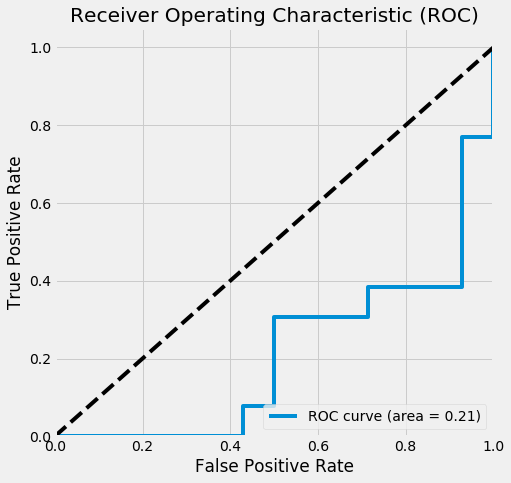

In [46]:
plot_roc(prediction_proba,y_test)

## To get better results I try 5 Fold CV in a loop with the LSTM. I report the ROC curves for each fold.

Fold #1


/home/leon/anaconda3/envs/tm/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Train on 83 samples, validate on 21 samples
Epoch 1/1

Epoch 00001: val_accuracy improved from -inf to 0.52381, saving model to best_model
27/27 [==============================] - 0s 4ms/step
Accuracy: 51.851851


Fold #2


/home/leon/anaconda3/envs/tm/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Train on 84 samples, validate on 21 samples
Epoch 1/1

Epoch 00001: val_accuracy improved from -inf to 0.42857, saving model to best_model
26/26 [==============================] - 0s 10ms/step
Accuracy: 42.307693


Fold #3


/home/leon/anaconda3/envs/tm/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Train on 84 samples, validate on 21 samples
Epoch 1/1

Epoch 00001: val_accuracy improved from -inf to 0.47619, saving model to best_model
26/26 [==============================] - 0s 5ms/step
Accuracy: 53.846157


Fold #4


/home/leon/anaconda3/envs/tm/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Train on 84 samples, validate on 21 samples
Epoch 1/1

Epoch 00001: val_accuracy improved from -inf to 0.42857, saving model to best_model
26/26 [==============================] - 0s 6ms/step
Accuracy: 61.538464


Fold #5


/home/leon/anaconda3/envs/tm/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Train on 84 samples, validate on 21 samples
Epoch 1/1

Epoch 00001: val_accuracy improved from -inf to 0.57143, saving model to best_model
26/26 [==============================] - 0s 7ms/step
Accuracy: 46.153846




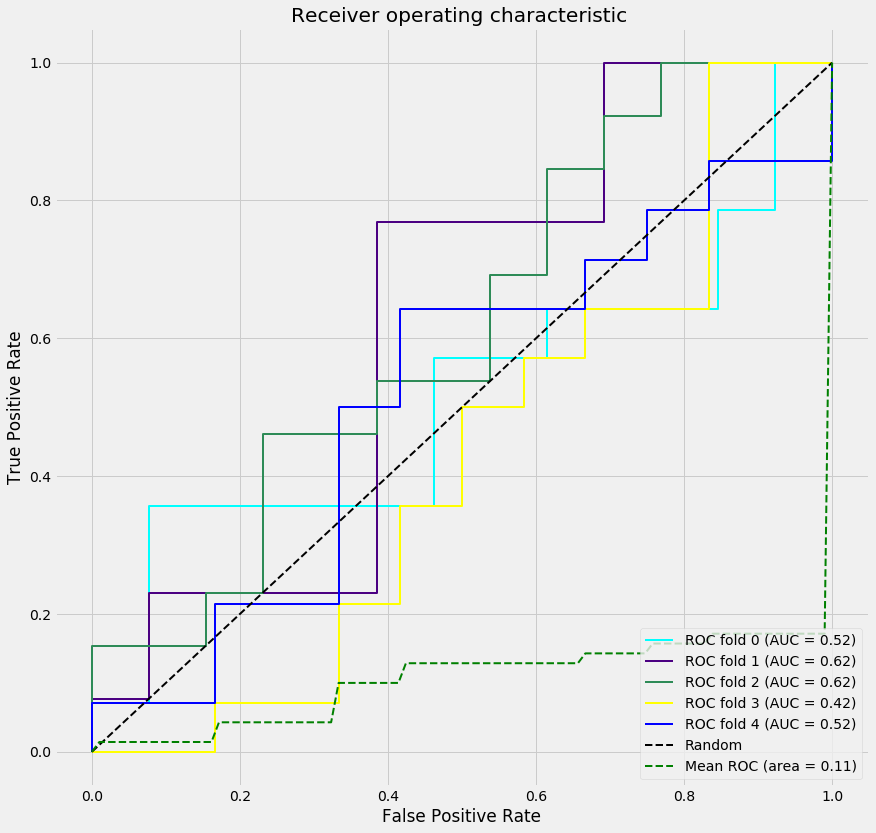

In [47]:
plt.rcParams["figure.figsize"] = (13,13)
# define folds
kf = StratifiedKFold(5, shuffle=True, random_state=42) 
i=0
fold = 0
colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
# apply the LSTM to the different folds by looping 
for (train, test), color in zip(kf.split(X, combined['dead']), colors):  
    fold += 1
    print(f"Fold #{fold}")
    
    # define model
    model = Sequential()
    model.add(Embedding(input_dim = vocab_size, output_dim = 32, input_length = max_length))
    model.add(Bidirectional(LSTM(64, activation='linear')))
    model.add(Dense(32, activation='linear'))
    model.add(Dense(1, activation='sigmoid'))
    
    X_train = X[train]
    y_train = y[train]
    X_test = X[test]
    y_test = y[test]
    
    # compile the model
    sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
    
    #early stopping when validation loss is at minimum & save best model measured by validation accuracy
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
    mc = ModelCheckpoint('best_model', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
    
    # fit model
    model.fit(X_train,
                        y_train,
                        validation_split=0.2,
                        verbose=100,
                        epochs=1,
                        callbacks=[es, mc])
    # results
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    print('Accuracy: %f' % (accuracy*100))
    print('\n')
    
    probas_ = model.predict(X_test)
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    
    lw = 2

    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 0])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    
    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Random')

mean_tpr /= kf.get_n_splits(X, y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ')
plt.legend(loc="lower right")
plt.show()
    

# Baseline models
Using same word embeddings as for the neural net


In [48]:
from sklearn import model_selection, naive_bayes, svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix

In [49]:
X = padded_docs
y = combined['dead']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Naive Bayes

In [50]:
#fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(X_train,y_train)

# predict the labels on validation dataset
predictions_NB = Naive.predict(X_test)

# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, y_test)*100)
print(confusion_matrix(predictions_NB,y_test))
print(classification_report(predictions_NB,y_test))

Naive Bayes Accuracy Score ->  37.03703703703704
[[ 2  5]
 [12  8]]
              precision    recall  f1-score   support

           0       0.14      0.29      0.19         7
           1       0.62      0.40      0.48        20

    accuracy                           0.37        27
   macro avg       0.38      0.34      0.34        27
weighted avg       0.49      0.37      0.41        27



## SVM

### Due to scale problems, I needed to create a special subset of the data for the SVM.

In [52]:
def balanced_subsample(y, size=None):
    
    '''Sample from data and keep the classes balanced'''

    subsample = []

    if size is None:
        n_smp = y.value_counts().min()
    else:
        n_smp = int(size / len(y.value_counts().index))

    for label in y.value_counts().index:
        samples = y[y == label].index.values
        index_range = range(samples.shape[0])
        indexes = np.random.choice(index_range, size=n_smp, replace=False)
        subsample += samples[indexes].tolist()

    return subsample

### Repeat the steps to create the input for LSTM (fed into SVM now)

In [53]:
# apply the function | here you can just play around with the size: maybe 1600, 1800, 2000, 2200 etc.
svm_sample = balanced_subsample(combined['dead'], round(len(combined)*0.3)) 

# extract the indices picked by the function to create subsample
svm_sample = combined.iloc[svm_sample, :]  
svm_sample = svm_sample.replace(np.nan, 1, regex=True) 
svm_sample = svm_sample[svm_sample['full'] != 1]

svm_text = svm_sample['full'].tolist()

svm_labels = svm_sample['dead'].tolist()

vocab_size = 5000
svm_encoded_docs = [one_hot(d, vocab_size) for d in svm_text]

max_length = 1500
svm_padded_docs = pad_sequences(svm_encoded_docs, maxlen=max_length, padding='post')

svm_X = svm_padded_docs
svm_y = svm_labels

svm_X_train, svm_X_test, svm_y_train, svm_y_test = train_test_split(svm_X, svm_y, test_size=0.6, random_state=42)

In [54]:
import numpy as np
print(np.shape(svm_X_train))
print(len(svm_y_train))
print(len(svm_y_test))
print(len(svm_sample))

(15, 1500)
15
23
38


In [ ]:
svm_sample.head(10)

In [56]:
svm_sample['dead'].value_counts()

1    19
0    19
Name: dead, dtype: int64

### Taking a percentage of all data for SVM

In [57]:
np.shape(svm_X_train)

(15, 1500)

In [58]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')

for i in tqdm(range(1)):
    SVM.fit(svm_X_train, svm_y_train)

# predict the labels on validation dataset
predictions_SVM = SVM.predict(svm_X_test)

# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, svm_y_test)*100)
#print(confusion_matrix(predictions_SVM, svm_y_test))
print(classification_report(predictions_SVM, svm_y_test))

100%|██████████| 1/1 [00:00<00:00, 302.31it/s]

SVM Accuracy Score ->  56.52173913043478
              precision    recall  f1-score   support

           0       0.90      0.50      0.64        18
           1       0.31      0.80      0.44         5

    accuracy                           0.57        23
   macro avg       0.60      0.65      0.54        23
weighted avg       0.77      0.57      0.60        23



## Logistic Regression

In [59]:
logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)

predictions_LR = logmodel.predict(X_test)

print("LR Accuracy -> ",accuracy_score(predictions_LR, y_test)*100)
print(classification_report(predictions_LR,y_test))

LR Accuracy ->  59.25925925925925
              precision    recall  f1-score   support

           0       0.71      0.59      0.65        17
           1       0.46      0.60      0.52        10

    accuracy                           0.59        27
   macro avg       0.59      0.59      0.58        27
weighted avg       0.62      0.59      0.60        27



/home/leon/anaconda3/envs/tm/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Using TF-IDF represenation as input

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [61]:
processed_text = combined['full']

In [62]:
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(processed_text)
print(tfidf.shape)
print('\n')
#print(vectorizer.get_feature_names())

(131, 4029)




In [63]:
y = labels

X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(tfidf, y, test_size=0.2, random_state=42)

## Naive Bayes

In [64]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(X_train_tf,y_train_tf)
# predict the labels on validation dataset
predictions_NB_tf = Naive.predict(X_test_tf)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy -> ",accuracy_score(predictions_NB_tf, y_test_tf)*100)
print(classification_report(predictions_NB_tf,y_test_tf))

Naive Bayes Accuracy ->  66.66666666666666
              precision    recall  f1-score   support

           0       0.71      0.67      0.69        15
           1       0.62      0.67      0.64        12

    accuracy                           0.67        27
   macro avg       0.66      0.67      0.66        27
weighted avg       0.67      0.67      0.67        27



## SVM

In [65]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(X_train_tf,y_train_tf)
# predict the labels on validation dataset
predictions_SVM_tf = SVM.predict(X_test_tf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy -> ",accuracy_score(predictions_SVM_tf, y_test_tf)*100)
print(classification_report(predictions_SVM_tf,y_test_tf))

SVM Accuracy ->  66.66666666666666
              precision    recall  f1-score   support

           0       0.71      0.67      0.69        15
           1       0.62      0.67      0.64        12

    accuracy                           0.67        27
   macro avg       0.66      0.67      0.66        27
weighted avg       0.67      0.67      0.67        27



## Logistic Regression

In [66]:
logmodel = LogisticRegression()
logmodel.fit(X_train_tf, y_train_tf)

predictions_LR_tf = logmodel.predict(X_test_tf)

print("LR Accuracy -> ",accuracy_score(predictions_LR_tf, y_test_tf)*100)
print(classification_report(predictions_LR_tf,y_test_tf))

LR Accuracy ->  62.96296296296296
              precision    recall  f1-score   support

           0       0.57      0.67      0.62        12
           1       0.69      0.60      0.64        15

    accuracy                           0.63        27
   macro avg       0.63      0.63      0.63        27
weighted avg       0.64      0.63      0.63        27



# ROC comparison for Baseline TF/IDF Models

Since those models receive a different input than our LSTM, does it make sense to add the LSTM performance in this graph as well? 

Or should we put the LSTM together with the baseline models which receive the LSTM input as well?

Text(0, 0.5, 'TP-rate')

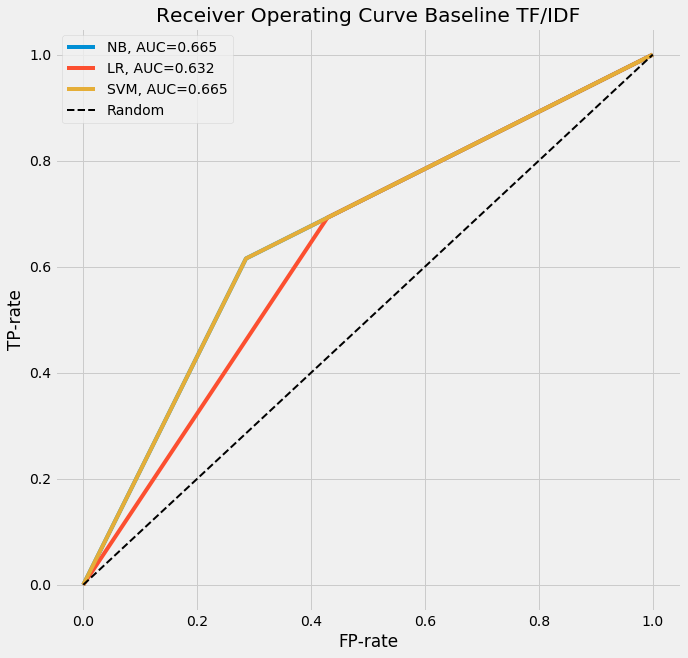

In [67]:
plt.rcParams["figure.figsize"] = (10,10)
lw = 2
plt.figure(0).clf()
plt.title('Receiver Operating Curve Baseline TF/IDF')


fpr, tpr, thresh = metrics.roc_curve(y_test_tf, predictions_NB_tf)
auc = round(metrics.roc_auc_score(y_test_tf, predictions_NB_tf), 3)
plt.plot(fpr,tpr,label="NB, AUC="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(y_test_tf, predictions_LR_tf)
auc = round(metrics.roc_auc_score(y_test_tf, predictions_LR_tf), 3)
plt.plot(fpr,tpr,label="LR, AUC="+str(auc))

fpr, tpr, thresh = metrics.roc_curve(y_test_tf, predictions_SVM_tf)
auc = round(metrics.roc_auc_score(y_test_tf, predictions_SVM_tf), 3)
plt.plot(fpr,tpr,label="SVM, AUC="+str(auc))

plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Random')

plt.legend(loc=0)
plt.xlabel('FP-rate')
plt.ylabel('TP-rate')

# Attention Model

In [68]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [69]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output


In [70]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [71]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, emded_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=emded_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=emded_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


In [72]:
max_length = 1500
vocab_size = 46468  
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(max_length,))
embedding_layer = TokenAndPositionEmbedding(max_length, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

att_model = keras.Model(inputs=inputs, outputs=outputs)


In [73]:
# the labels were encoded as pandas array before, 
# it threw an error for the model below so I transformed it into numpy array
labels = np.array(labels)


In [74]:
from keras import optimizers
from keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [75]:
type(y_train)

pandas.core.series.Series

In [76]:
# compile the model
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
att_model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

#early stopping when validation loss is at minimum 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

# fit model
att_model.fit(padded_docs,
          labels,
          validation_split=0.2,
          verbose=1,
          epochs=10,
          callbacks=[es])
# results
loss, accuracy = att_model.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))

Epoch 1/10
4/4 [==============================] - 3s 781ms/step - loss: 0.7433 - accuracy: 0.5481 - val_loss: 0.6874 - val_accuracy: 0.5556
Epoch 2/10
4/4 [==============================] - 3s 720ms/step - loss: 0.6940 - accuracy: 0.5385 - val_loss: 0.6877 - val_accuracy: 0.5556
Epoch 3/10
4/4 [==============================] - 3s 716ms/step - loss: 0.7261 - accuracy: 0.4712 - val_loss: 0.6873 - val_accuracy: 0.5556
Epoch 4/10
4/4 [==============================] - 3s 730ms/step - loss: 0.6880 - accuracy: 0.5673 - val_loss: 0.6902 - val_accuracy: 0.5556
Epoch 5/10
4/4 [==============================] - 3s 729ms/step - loss: 0.7159 - accuracy: 0.4615 - val_loss: 0.6967 - val_accuracy: 0.4444
Epoch 6/10
4/4 [==============================] - 4s 902ms/step - loss: 0.6833 - accuracy: 0.5769 - val_loss: 0.6898 - val_accuracy: 0.5556
Epoch 7/10
4/4 [==============================] - 4s 897ms/step - loss: 0.7234 - accuracy: 0.4712 - val_loss: 0.6874 - val_accuracy: 0.5556
Epoch 8/10
4/4 [====